## Employee Retention
### Goal
Employee turn-over is a very costly problem for companies. The cost of replacing an employee
if often larger than 100K USD, taking into account the time spent to interview and find a
replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

It is only natural then that data science has started being applied to this area. Understanding
why and when employees are most likely to leave can lead to actions to improve employee
retention as well as planning new hiring in advance. This application of DS is sometimes called
people analytics or people data science (if you see a job title: people data scientist, this is your
job).

In this challenge, you have a data set with info about the employees and have to predict when
employees are going to quit by understanding the main drivers of employee churn.

### Challenge Description
We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the
company as of 2015/12/13 or they have quit. Beside that, we have general info about the
employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers.
Specifically, you should:

    1. Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
    employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
    That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
    already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
    You should create a table with 3 columns: day, employee_headcount, company_id.
    2. What are the main factors that drive employee churn? Do they make sense? Explain your
    findings.
    3. If you could add to this data set just one variable that could help explain employee churn,
    what would that be?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import linear_model, preprocessing, tree, model_selection
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier, RandomForestRegressor, BaggingClassifier

In [2]:
employeedata = pd.read_csv('03-employee_retention_data.csv')

In [3]:
employeedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [4]:
employeedata.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [5]:
employeedata[['dept', 'join_date', 'quit_date']].describe()

,dept,join_date,quit_date
count,24702,24702,13510
unique,6,995,664
top,customer_service,1/3/2012,5/8/2015
freq,9180,105,111


In [6]:
employeedata.sample(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
10026,630093.0,1,customer_service,25,112000.0,2/19/2013,2/14/2014
16959,135769.0,4,marketing,23,152000.0,4/2/2013,5/2/2014
10758,674053.0,5,sales,8,94000.0,7/22/2013,2/27/2015
9526,780705.0,1,customer_service,4,28000.0,12/31/2012,NaN
1018,93675.0,5,customer_service,14,62000.0,3/19/2013,2/14/2014


In [7]:
employeedata.loc[employeedata['company_id'] == 1].sample(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
3367,377843.0,1,engineer,13,179000.0,9/13/2011,8/9/2013
3183,324765.0,1,sales,21,210000.0,1/5/2015,NaN
16031,831560.0,1,data_science,12,204000.0,7/2/2012,7/26/2013
12794,884053.0,1,customer_service,9,72000.0,11/26/2012,9/18/2015
22345,738018.0,1,marketing,12,121000.0,6/28/2011,9/28/2012


In [8]:
employeedata['join_date'].unique()

array(['3/24/2014', '4/29/2013', '10/13/2014', '5/14/2012', '10/17/2011',
       '1/30/2012', '10/21/2013', '3/5/2014', '12/10/2012', '6/12/2012',
       '11/12/2012', '5/11/2015', '6/18/2012', '9/16/2013', '5/27/2014',
       '11/30/2011', '3/31/2014', '12/29/2014', '7/27/2015', '10/19/2015',
       '6/25/2012', '11/28/2011', '8/20/2013', '7/29/2013', '5/31/2011',
       '8/26/2013', '3/21/2011', '8/1/2011', '2/14/2011', '6/8/2015',
       '7/16/2012', '3/31/2015', '5/20/2013', '8/26/2014', '3/11/2013',
       '10/8/2012', '4/13/2015', '3/18/2013', '4/21/2014', '6/13/2011',
       '2/21/2012', '8/18/2014', '3/16/2015', '5/4/2015', '7/30/2012',
       '7/29/2014', '1/9/2012', '5/7/2012', '12/16/2013', '6/4/2012',
       '3/12/2012', '7/15/2013', '8/27/2012', '9/14/2011', '9/2/2014',
       '11/24/2014', '10/7/2013', '3/23/2015', '10/22/2012', '6/3/2013',
       '1/23/2012', '3/13/2013', '4/18/2011', '3/30/2015', '8/2/2011',
       '11/16/2015', '12/1/2014', '3/10/2014', '7/13/2015', '7

In [9]:
employeedata['join_date'] = pd.to_datetime(employeedata['join_date']).dt.date
employeedata['quit_date'] = pd.to_datetime(employeedata['quit_date']).dt.date

In [10]:
employeedata['quit_date'].sort_values().unique()

array([datetime.date(2011, 10, 13), datetime.date(2011, 10, 14),
       datetime.date(2011, 10, 21), datetime.date(2011, 10, 28),
       datetime.date(2011, 11, 11), datetime.date(2011, 11, 22),
       datetime.date(2011, 11, 25), datetime.date(2011, 12, 2),
       datetime.date(2011, 12, 9), datetime.date(2011, 12, 13),
       datetime.date(2011, 12, 16), datetime.date(2011, 12, 23),
       datetime.date(2011, 12, 30), datetime.date(2012, 1, 3),
       datetime.date(2012, 1, 5), datetime.date(2012, 1, 6),
       datetime.date(2012, 1, 9), datetime.date(2012, 1, 13),
       datetime.date(2012, 1, 17), datetime.date(2012, 1, 18),
       datetime.date(2012, 1, 19), datetime.date(2012, 1, 20),
       datetime.date(2012, 1, 24), datetime.date(2012, 1, 27),
       datetime.date(2012, 1, 30), datetime.date(2012, 2, 2),
       datetime.date(2012, 2, 3), datetime.date(2012, 2, 7),
       datetime.date(2012, 2, 10), datetime.date(2012, 2, 15),
       datetime.date(2012, 2, 17), datetime.date(20

In [11]:
employeedata.loc[employeedata['company_id'] == 1].sort_values(by='join_date').head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
15285,554358.0,1,customer_service,8,67000.0,2011-01-24,2013-03-01
18458,477885.0,1,customer_service,25,121000.0,2011-01-24,2013-06-07
9047,235489.0,1,customer_service,29,140000.0,2011-01-24,2011-12-30
15730,396978.0,1,data_science,4,68000.0,2011-01-24,2013-02-08
15523,581263.0,1,sales,5,118000.0,2011-01-24,2011-10-21


In [12]:
dates = pd.date_range(start = '2011-01-24', end = '2015-12-13')
datecolumn = pd.DataFrame({'date':dates})
datecolumn['key'] = 0

In [13]:
len(dates)

1785

In [14]:
uniqcompany = employeedata.company_id.unique()
companycolumn = pd.DataFrame({'company_id': uniqcompany})
companycolumn['key'] = 0

In [15]:
headcount = pd.merge(datecolumn, companycolumn, on='key')
headcount.drop('key', axis=1, inplace=True)

In [16]:
headcount.head()

,date,company_id
0,2011-01-24,7
1,2011-01-24,4
2,2011-01-24,2
3,2011-01-24,9
4,2011-01-24,1


In [17]:
employeein = employeedata.groupby(['company_id', 'join_date'])['company_id','join_date'].sum()  #similar to count(), but need 2 columns to create a dataframe 
employeein.columns = ['number_join']
employeein.reset_index(inplace=True)
employeein.columns = ['company_id', 'date', 'number_join']
employeein.date = pd.to_datetime(employeein.date)
employeein.head()

,company_id,date,number_join
0,1,2011-01-24,25
1,1,2011-01-25,2
2,1,2011-01-26,2
3,1,2011-01-31,30
4,1,2011-02-01,7


In [18]:
employeeout = employeedata.groupby(['company_id', 'quit_date'])['company_id','quit_date'].sum()  #similar to count(), but need 2 columns to create a dataframe 
employeeout.columns = ['number_quit']
employeeout.reset_index(inplace=True)
employeeout.columns = ['company_id', 'date', 'number_quit']
employeeout.date = pd.to_datetime(employeeout.date)
employeeout.head()

,company_id,date,number_quit
0,1,2011-10-21,1
1,1,2011-11-11,1
2,1,2011-11-22,1
3,1,2011-11-25,1
4,1,2011-12-09,1


In [19]:
##to create a talbe with 3 columes: day, employee_headcount, company_id
headcount_sum = pd.merge(headcount, employeein, on=['company_id', 'date'], how='left').fillna(0)
headcount_sum = pd.merge(headcount_sum, employeeout, on=['company_id', 'date'], how='left').fillna(0)
headcount_sum.sample(5)

,date,company_id,number_join,number_quit
12806,2013-12-26,2,2.0,4.0
19280,2015-06-18,3,0.0,0.0
8164,2012-12-04,1,1.0,0.0
2769,2011-09-11,8,0.0,0.0
16972,2014-12-08,1,28.0,0.0


In [20]:
headcount_sum['dailycount'] = headcount_sum['number_join'] - headcount_sum['number_quit']
headcount_sum.sample(5)

,date,company_id,number_join,number_quit,dailycount
9077,2013-02-18,6,0.0,0.0,0.0
5548,2012-04-30,1,39.0,0.0,39.0
10300,2013-05-31,1,1.0,21.0,-20.0
511,2011-03-07,5,50.0,0.0,50.0
10137,2013-05-17,8,0.0,16.0,-16.0


In [21]:
headcount_sum.groupby(['date', 'company_id']).sum().groupby(['company_id']).cumsum()

number_join  number_quit  dailycount
date       company_id                                      
2011-01-24 1                  25.0          0.0        25.0
           2                  34.0          0.0        34.0
           3                  27.0          0.0        27.0
           4                  48.0          0.0        48.0
           5                  25.0          0.0        25.0
           6                  18.0          0.0        18.0
           7                   7.0          0.0         7.0
           8                  48.0          0.0        48.0
           9                  27.0          0.0        27.0
           10                  0.0          0.0         0.0
           11                  0.0          0.0         0.0
           12                  0.0          0.0         0.0
2011-01-25 1                  27.0          0.0        27.0
           2                  38.0          0.0        38.0
           3                  30.0          0.0        30.0
           4                  48.0          0.0        48.0
           5                  25.0          0.0        25.0
           6                  18.0          0.0        18.0
           7                   7.0          0.0         7.0
           8                  48.0          0.0        48.0
           9                  27.0          0.0        27.0
           10                  0.0          0.0         0.0
           11                  0.0          0.0         0.0
           12                  0.0          0.0         0.0
2011-01-26 1                  29.0          0.0        29.0
           2                  38.0          0.0        38.0
           3                  36.0          0.0        36.0
           4                  52.0          0.0        52.0
           5                  30.0          0.0        30.0
           6                  18.0          0.0        18.0
...                            ...          ...         ...
2015-12-11 7                8568.0       4844.0      3724.0
           8                8376.0       4632.0      3744.0
           9                8649.0       4761.0      3888.0
           10               8650.0       4800.0      3850.0
           11                176.0        132.0        44.0
           12                288.0        144.0       144.0
2015-12-12 1                8486.0       4621.0      3865.0
           2                8444.0       4412.0      4032.0
           3                8247.0       4593.0      3654.0
           4                8248.0       4612.0      3636.0
           5                8775.0       4915.0      3860.0
           6                7746.0       4272.0      3474.0
           7                8568.0       4844.0      3724.0
           8                8376.0       4632.0      3744.0
           9                8649.0       4761.0      3888.0
           10               8650.0       4800.0      3850.0
           11                176.0        132.0        44.0
           12                288.0        144.0       144.0
2015-12-13 1                8486.0       4621.0      3865.0
           2                8444.0       4412.0      4032.0
           3                8247.0       4593.0      3654.0
           4                8248.0       4612.0      3636.0
           5                8775.0       4915.0      3860.0
           6                7746.0       4272.0      3474.0
           7                8568.0       4844.0      3724.0
           8                8376.0       4632.0      3744.0
           9                8649.0       4761.0      3888.0
           10               8650.0       4800.0      3850.0
           11                176.0        132.0        44.0
           12                288.0        144.0       144.0

[21420 rows x 3 columns]

In [22]:
headcount_sum2 = headcount_sum.groupby(['date', 'company_id']).sum().groupby(['company_id']).cumsum()
headcount_sum2.reset_index(inplace=True)
headcount_sum2.tail(12)

,date,company_id,number_join,number_quit,dailycount
21408,2015-12-13,1,8486.0,4621.0,3865.0
21409,2015-12-13,2,8444.0,4412.0,4032.0
21410,2015-12-13,3,8247.0,4593.0,3654.0
21411,2015-12-13,4,8248.0,4612.0,3636.0
21412,2015-12-13,5,8775.0,4915.0,3860.0
21413,2015-12-13,6,7746.0,4272.0,3474.0
21414,2015-12-13,7,8568.0,4844.0,3724.0
21415,2015-12-13,8,8376.0,4632.0,3744.0
21416,2015-12-13,9,8649.0,4761.0,3888.0
21417,2015-12-13,10,8650.0,4800.0,3850.0


In [23]:
headcount_sum.groupby(['company_id']).mean()

,number_join,number_quit,dailycount
company_id,,,
1,4.754062,2.588796,2.165266
2,4.730532,2.471709,2.258824
3,4.620168,2.573109,2.047059
4,4.620728,2.583754,2.036975
5,4.915966,2.753501,2.162465
6,4.339496,2.393277,1.946218
7,4.800000,2.713725,2.086275
8,4.692437,2.594958,2.097479
9,4.845378,2.667227,2.178151


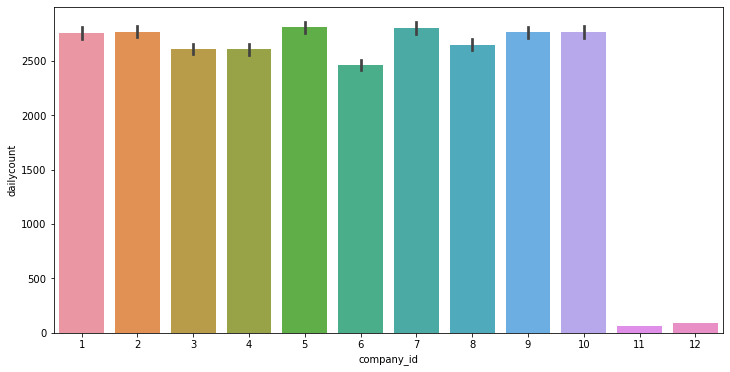

In [24]:
## visualize the cumcount over different companies
plt.figure(figsize=(12,6))
sns.barplot(x='company_id', y='dailycount', data=headcount_sum2)
plt.show()

In [25]:
total_join = headcount_sum.groupby(['company_id']).number_join.sum()

In [26]:
total_quit = headcount_sum.groupby(['company_id']).number_quit.sum()
total_quit.head()

company_id
1    4621.0
2    4412.0
3    4593.0
4    4612.0
5    4915.0
Name: number_quit, dtype: float64

In [27]:
#total_inandout = pd.merge(total_join, total_quit, on='company_id')
total_inandout = pd.concat([total_join, total_quit], axis=1)
total_inandout.reset_index(inplace=True)
total_inandout['retentionrate'] = ((total_inandout['number_join'] - total_inandout['number_quit']) / total_inandout['number_join']).round(3)
total_inandout.sample()

,company_id,number_join,number_quit,retentionrate
9,10,8650.0,4800.0,0.445


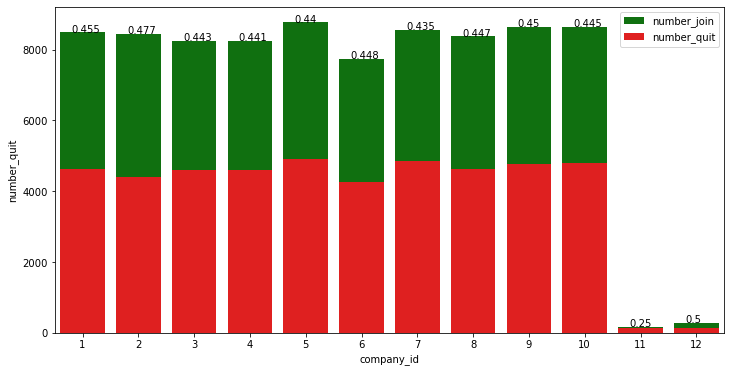

In [28]:
plt.figure(figsize=(12,6))
plot1=sns.barplot(x='company_id', y='number_join', data=total_inandout, color='green', label='number_join')
plot2=sns.barplot(x='company_id', y='number_quit', data=total_inandout, color='red', label='number_quit')
plt.legend(loc='upper right')

for each in range(0, 12):
    plot1.text(total_inandout.company_id[each]-1.2, total_inandout.number_join[each], \
               total_inandout.retentionrate[each])
    
plt.show()

### The company 11 has the lowest retention rate, while company 12 has the highest retention rate, even though they all have much less headcount of people hired.

In [29]:
employeedata[employeedata.company_id == 11].sort_values(by=['quit_date'])

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
13469,402615.0,11,customer_service,13,40000.0,2011-10-31,2012-12-07
12485,422612.0,11,engineer,20,175000.0,2012-06-18,2013-06-07
1836,296591.0,11,data_science,8,115000.0,2011-02-22,2013-06-21
13362,236291.0,11,customer_service,1,21000.0,2013-01-15,2014-01-24
389,952116.0,11,engineer,18,177000.0,2013-02-05,2014-02-21
9824,814745.0,11,marketing,23,114000.0,2011-12-27,2014-03-28
248,425545.0,11,engineer,26,203000.0,2013-09-12,2014-07-18
2503,692121.0,11,marketing,23,135000.0,2012-03-26,2014-08-08
4889,1012.0,11,data_science,25,192000.0,2013-02-25,2014-08-15
20514,168850.0,11,engineer,5,130000.0,2014-02-10,2015-01-30


In [30]:
employeedata[employeedata.company_id == 12].sort_values(by=['quit_date'])

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
6183,81036.0,12,customer_service,20,64000.0,2011-03-14,2012-02-24
2750,582569.0,12,customer_service,3,18000.0,2011-05-16,2012-05-04
874,214527.0,12,customer_service,17,79000.0,2011-06-06,2012-05-18
7013,735950.0,12,customer_service,9,42000.0,2012-03-12,2013-04-05
8137,988621.0,12,engineer,3,45000.0,2012-07-02,2013-05-10
4853,426716.0,12,data_science,21,187000.0,2011-10-13,2013-07-12
1680,824438.0,12,sales,22,109000.0,2011-06-20,2013-10-18
10255,808516.0,12,customer_service,3,18000.0,2012-11-12,2013-10-25
5177,67874.0,12,sales,5,88000.0,2013-03-11,2014-02-07
16599,165867.0,12,customer_service,10,42000.0,2012-11-26,2014-09-19


In [31]:
stay_data = employeedata[employeedata['quit_date'].isnull()]
quit_data = employeedata[~employeedata['quit_date'].isnull()]
quit_data['tenure'] = (pd.to_datetime(employeedata.quit_date) - \
                       pd.to_datetime(employeedata.join_date)).dt.days  ##convert format from timedelta64 to float64
quit_data.head()


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,tenure
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578.0


In [32]:
quit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13510 entries, 0 to 24701
Data columns (total 8 columns):
employee_id    13510 non-null float64
company_id     13510 non-null int64
dept           13510 non-null object
seniority      13510 non-null int64
salary         13510 non-null float64
join_date      13510 non-null object
quit_date      13510 non-null object
tenure         13510 non-null float64
dtypes: float64(3), int64(2), object(3)
memory usage: 949.9+ KB


In [33]:
employeedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [34]:
quit_data.company_id.value_counts()

1     4621
2     2206
3     1531
4     1153
5      983
6      712
7      692
8      579
9      529
10     480
12      12
11      12
Name: company_id, dtype: int64

In [35]:
employeedata.company_id.value_counts()

1     8486
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     865
12      24
11      16
Name: company_id, dtype: int64

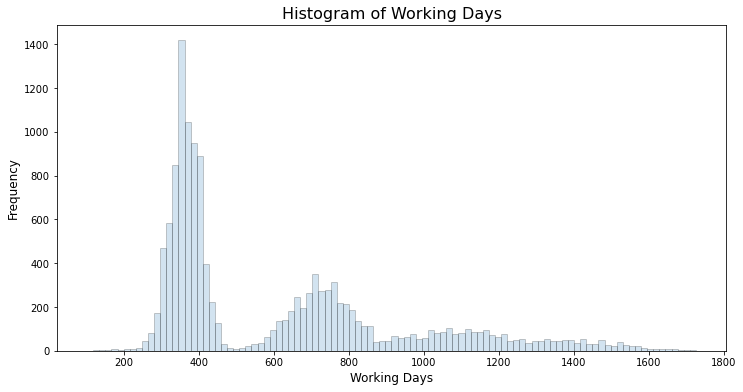

In [36]:
plt.figure(figsize=(12,6))
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
sns.distplot(quit_data.tenure, bins=100, kde=False, hist_kws=hist_kws)
plt.title('Histogram of Working Days', fontsize=16)
plt.xlabel('Working Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

### Most quit happens around one year, there is a big spike there, people leave after receiving anual bonus? 
### Another smaller peak happens around 2 years, after 2.5 years, the quit rate is smaller.


In [37]:
quit_data.dept.unique()
quit_data['dept_code'] = quit_data.dept.map({'customer_service':0, 'marketing':1, 'data_science':2, 'engineer':3,
       'sales':4, 'design':5})
stay_data['dept_code'] = stay_data.dept.map({'customer_service':0, 'marketing':1, 'data_science':2, 'engineer':3,
       'sales':4, 'design':5})

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [38]:
company_quit = quit_data.groupby(['company_id']).employee_id.count()
company_total = employeedata.groupby(['company_id']).employee_id.count()
company_quitrate = company_quit.divide(company_total)
#company_quitrate
print(company_quit, company_total)

company_id
1     4621
2     2206
3     1531
4     1153
5      983
6      712
7      692
8      579
9      529
10     480
11      12
12      12
Name: employee_id, dtype: int64 company_id
1     8486
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     865
11      16
12      24
Name: employee_id, dtype: int64


In [39]:
quitbycompany = quit_data.groupby(['company_id']).employee_id.count()/employeedata.groupby(['company_id']).employee_id.count()
quitbydept = quit_data.groupby(['dept']).employee_id.count()/employeedata.groupby(['dept']).employee_id.count()
quitbyseniority = quit_data.groupby(['seniority']).employee_id.count()/employeedata.groupby(['seniority']).employee_id.count()
quitbysalary = quit_data.groupby(['salary']).employee_id.count()/employeedata.groupby(['salary']).employee_id.count()
quitbycompany

company_id
1     0.544544
2     0.522501
3     0.556930
4     0.559166
5     0.560114
6     0.551510
7     0.565359
8     0.553009
9     0.550468
10    0.554913
11    0.750000
12    0.500000
Name: employee_id, dtype: float64

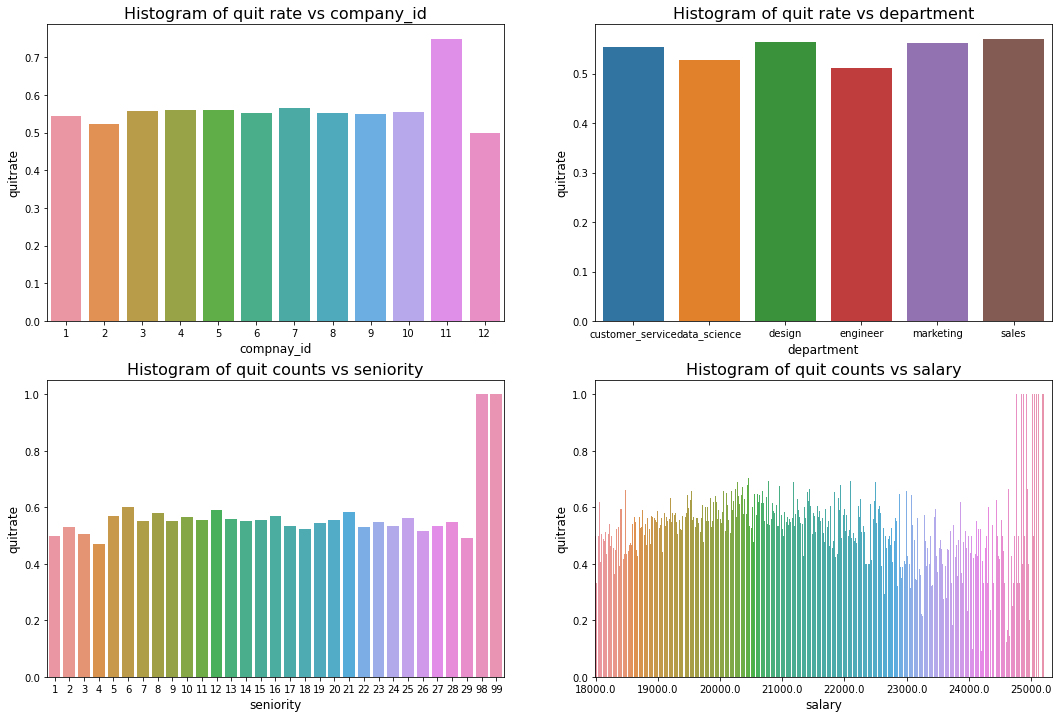

In [40]:
import matplotlib.ticker as ticker

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
sns.barplot(x=quitbycompany.index, y=quitbycompany)
plt.title('Histogram of quit rate vs company_id', fontsize=16)
plt.xlabel('compnay_id', fontsize=12)
plt.ylabel('quitrate', fontsize=12)
plt.subplot(2,2,2)
sns.barplot(x=quitbydept.index, y=quitbydept)
plt.title('Histogram of quit rate vs department', fontsize=16)
plt.xlabel('department', fontsize=12)
plt.ylabel('quitrate', fontsize=12)
plt.subplot(2,2,3)
sns.barplot(x=quitbyseniority.index, y=quitbyseniority)
plt.title('Histogram of quit counts vs seniority', fontsize=16)
plt.xlabel('seniority', fontsize=12)
plt.ylabel('quitrate', fontsize=12)
plt.subplot(2,2,4)
ax=sns.barplot(x=quitbysalary.index, y=quitbysalary)
plt.title('Histogram of quit counts vs salary', fontsize=16)
plt.xlabel('salary', fontsize=12)
plt.ylabel('quitrate', fontsize=12)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.show()


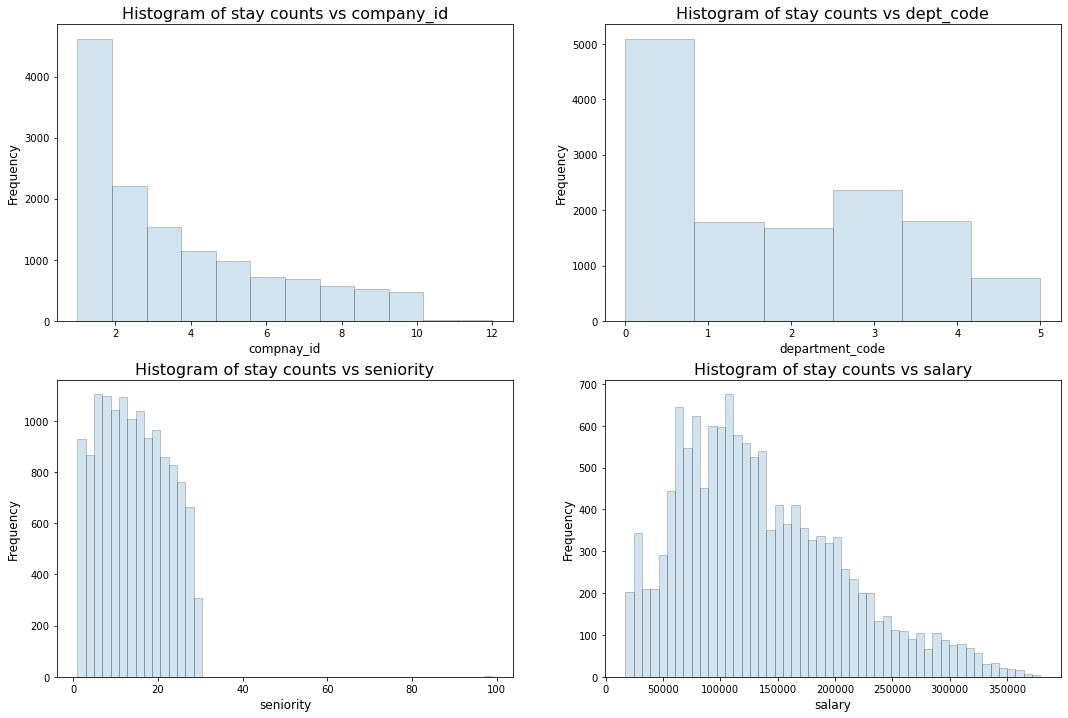

In [41]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
sns.distplot(quit_data.company_id, bins=12, kde=False, hist_kws=hist_kws)
plt.title('Histogram of stay counts vs company_id', fontsize=16)
plt.xlabel('compnay_id', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.subplot(2,2,2)
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
sns.distplot(quit_data.dept_code, bins=6, kde=False, hist_kws=hist_kws)
plt.title('Histogram of stay counts vs dept_code', fontsize=16)
plt.xlabel('department_code', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.subplot(2,2,3)
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
sns.distplot(quit_data.seniority, bins=50, kde=False, hist_kws=hist_kws)
plt.title('Histogram of stay counts vs seniority', fontsize=16)
plt.xlabel('seniority', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.subplot(2,2,4)
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
sns.distplot(quit_data.salary, bins=50, kde=False, hist_kws=hist_kws)
plt.title('Histogram of stay counts vs salary', fontsize=16)
plt.xlabel('salary', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

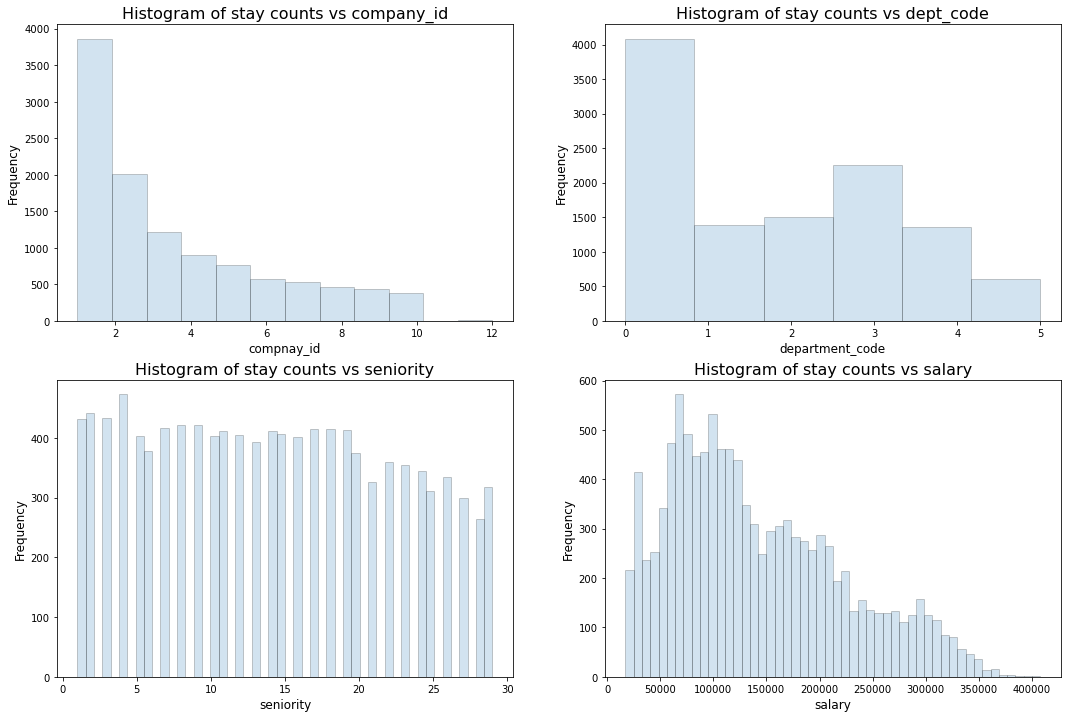

In [42]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
sns.distplot(stay_data.company_id, bins=12, kde=False, hist_kws=hist_kws)
plt.title('Histogram of stay counts vs company_id', fontsize=16)
plt.xlabel('compnay_id', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.subplot(2,2,2)
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
sns.distplot(stay_data.dept_code, bins=6, kde=False, hist_kws=hist_kws)
plt.title('Histogram of stay counts vs dept_code', fontsize=16)
plt.xlabel('department_code', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.subplot(2,2,3)
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
sns.distplot(stay_data.seniority, bins=50, kde=False, hist_kws=hist_kws)
plt.title('Histogram of stay counts vs seniority', fontsize=16)
plt.xlabel('seniority', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.subplot(2,2,4)
hist_kws={'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.2}
sns.distplot(stay_data.salary, bins=50, kde=False, hist_kws=hist_kws)
plt.title('Histogram of stay counts vs salary', fontsize=16)
plt.xlabel('salary', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

#### Dept coding: 'customer_service':0, 'marketing':1, 'data_science':2, 'engineer':3, 'sales':4, 'design':5
#### the quit count is decreasing as company_id from 1 - 12
#### the highest quit count happens at customer_service dept, then design, sales, data_science, engineer
#### the from seniority of 5 years to 30 years, the quit count is decreasing
#### the highest quit count happens between the salary range of 75k to 130k.

### Use machine learning algorithms to train a model and ouput the coefficient of importance to each factors.

In [43]:
temp = employeedata[['company_id', 'dept', 'seniority', 'salary', 'quit_date']]
temp['stay'] = 0
temp.loc[temp.quit_date.isnull(),'stay'] = 1
dept_dummy = pd.get_dummies(temp['dept'], prefix='dept')
temp = temp[['company_id', 'seniority', 'salary', 'stay']].join(dept_dummy)
editedinput = temp
editedinput.sample(12)

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
b:\program files\phthon\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,company_id,seniority,salary,stay,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
3445,6,10,67000.0,0,1,0,0,0,0,0
20751,2,13,77000.0,1,1,0,0,0,0,0
21740,4,16,159000.0,0,0,0,0,0,1,0
150,1,10,201000.0,0,0,0,0,1,0,0
21319,10,20,250000.0,0,0,0,0,1,0,0
19210,1,22,334000.0,0,0,0,0,1,0,0
6184,2,24,173000.0,1,0,0,0,0,0,1
16808,1,7,187000.0,1,0,1,0,0,0,0
7649,2,26,170000.0,1,0,0,1,0,0,0
19568,10,23,226000.0,1,0,0,0,1,0,0


In [59]:
temp = employeedata[['company_id', 'dept', 'seniority', 'salary', 'quit_date']]
temp['stay'] = 0
temp.loc[temp.quit_date.isnull(),'stay'] = 1
le = LabelEncoder()
feat2 = temp[['company_id', 'seniority', 'salary']]
feat2['dept'] = le.fit_transform(temp['dept'])
target2 = temp['stay']
print(feat2[:10], target2[:10])

b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
b:\program files\phthon\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


   company_id  seniority    salary  dept
0           7         28   89000.0     0
1           7         20  183000.0     4
2           4         14  101000.0     4
3           7         20  115000.0     0
4           2         23  276000.0     1
5           4         14  165000.0     1
6           4         21  107000.0     0
7           2          4   30000.0     0
8           9          7  160000.0     3
9           1          7  104000.0     5 0    0
1    0
2    1
3    0
4    0
5    0
6    1
7    1
8    0
9    1
Name: stay, dtype: int64


b:\program files\phthon\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
## data split
target = editedinput['stay']#.values
features = editedinput.drop(['stay'], axis=1)#.values
train_x, test_x, train_y, test_y = train_test_split(feat2, target2, test_size = 0.15, random_state=0)

In [52]:
print(train_x[:10], train_y[:10])

       company_id  seniority    salary  dept_customer_service  \
15447           1         21  122000.0                      1   
13768           3          7  152000.0                      0   
23004           3         11   56000.0                      1   
21774           4          8  182000.0                      0   
17467           9         24  224000.0                      0   
21659           2         11  125000.0                      0   
13895           1         21  128000.0                      1   
14968           1         22  219000.0                      0   
7086            1         22  212000.0                      0   
12202           1          7  190000.0                      0   

       dept_data_science  dept_design  dept_engineer  dept_marketing  \
15447                  0            0              0               0   
13768                  0            0              1               0   
23004                  0            0              0               0

In [65]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20996 entries, 15447 to 2732
Data columns (total 4 columns):
company_id    20996 non-null int64
seniority     20996 non-null int64
salary        20996 non-null float64
dept          20996 non-null int32
dtypes: float64(1), int32(1), int64(2)
memory usage: 738.1 KB


In [78]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

n_estimators = [int(x) for x in np.linspace(50, 400, 20)]
max_depth = [int(x) for x in np.linspace(5, 35, 5)]

random_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}

rf = RandomForestClassifier()
rf_random = GridSearchCV(estimator=rf, param_grid=random_grid, cv=4, verbose=2, n_jobs=-1)
rf_random.fit(train_x, train_y)    
print(rf_random.best_params_, rf_random.best_score_)


Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.8min finished


{'max_depth': 5, 'n_estimators': 68} 0.5636311678414936


In [63]:
rfc = RandomForestClassifier(n_estimators=68, max_depth=5, max_features=1, random_state=0).fit(train_x, train_y)
cvscores = model_selection.cross_val_score(rfc, train_x, train_y, scoring='accuracy', cv=5)
print(cvscores.mean())
print(rfc.score(train_x, train_y))

0.560535376903798
0.5730139074109354
